In [1]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters

import tensorflow as tf
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D , Conv3D, Layer, MaxPooling2D, Dropout, Flatten, Dense, GRU, ConvLSTM2D, Input, BatchNormalization, TimeDistributed, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from random import shuffle
from tensorflow.keras.regularizers import l2

# from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model, load_model


# import cv2
# import imageio
# import cv2

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
# import IPython
# from six.moves import urllib
print(tf.__version__)
print(keras.__version__)
import pydicom
import re
import math
import random
# import bisect
np.random.seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 1024
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 2
NUM_SCANS = 8
NUM_CHANNELS = 1
INPUT_DIM = 256

keras.utils.set_random_seed(1)
random.seed(1)
np.random.seed(1)

2.8.1
2.8.0
Num GPUs Available:  1


In [3]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
all_ids = all_ids.drop_duplicates('StudyInstanceUID')
fold_df = pd.read_csv('folds.csv')
    

/tmp/ipykernel_2449029/3496039043.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [5]:
# for fold in range(0):
fold = 0
directory = '/home/shared/nps/coat_np_0' + str(fold) + '/'

lisdir = os.listdir(directory)
print('hello?')
print(len(lisdir))

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')
files = pd.merge(files, all_ids)
files = files.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image','ycoord', 'contains_lung'])
files = pd.merge(files, fold_df)


hello?
6806


/tmp/ipykernel_2449029/3390104419.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [ ]:
num_features = 64
MAX_SEQ_LENGTH = 200

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, num_features, directory,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, full_set = None, random=False, set_type='test',
                 feat_type = 'feats', oversample=True, crop=False ):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_features = num_features
        self.seq_length = seq_length
        self.full_set = full_set
        self.return_type = return_type
        self.random = random
        warnings.filterwarnings(action='ignore')
        self.directory = directory
        self.set_type = set_type
        self.feat_type = feat_type
        self.oversample=oversample
        self.crop= crop
        
        if self.set_type == 'val':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
            self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        self.on_epoch_end()
            
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        x_feats = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            x_feats[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
        if self.to_fit:
            if self.return_type =='both':
                y = [np.array(y_seq), y_tot]
            elif self.return_type == 'seq':
                y = y_seq
            elif self.return_type == 'tot':
                y = y_tot
            else:
                print('valid return types are both, seq and tot')
                return False
            x = x_feats
            return x, y
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True]
            if self.oversample == False:
                self.study_ids = pd.concat([sample_pos, sample_neg.sample(n=len(sample_pos))]).sample(frac=1).reset_index(drop=True)
            else:
                self.study_ids = pd.concat([sample_pos.sample(n=len(sample_neg), replace=True), sample_neg]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = pd.DataFrame(np.load(self.directory +study_id + '.npy', allow_pickle=True).tolist())
        scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
        scan = scan.sort_values(by=['ycoord'], ascending=False).reset_index(drop=True)
        
        features = scan.features.tolist()
        seq = scan.pe_present_on_image.tolist()
        seq = np.reshape(seq, [len(seq),1])
        tot = self.study_ids[self.study_ids.StudyInstanceUID == study_id].negative_exam_for_pe.iloc[0]
        
        if self.set_type == 'train' and self.random == True:
            new_len = int(len(scan) * (random.random()*0.2 +0.9))
            inst = np.round(np.arange(0,new_len)/new_len*len(features)).astype(int)
            features = (np.array(features)[inst]).tolist()
            seq = seq[inst]   
        
        if len(features)>=self.seq_length:
            if self.crop==False:
                inst = np.round(np.arange(0,self.seq_length)/self.seq_length*len(features)).astype(int)
                xs = (np.array(features)[inst]).tolist()
                ys = seq[inst]
            if self.crop==True:
                xs = (np.array(features)[:self.seq_length]).tolist()
                ys = seq[:self.seq_length]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])

            start = int(np.floor(self.seq_length - len(features)))
            end = start + len(features)
            xs[start:end] = features
            ys[start:end] = seq

        ys = ys.tolist()
                    
        return (xs, [ys, tot])

    
def get_generators(df, fold, batch_size, out, feat, random, seq_len=200, crop=True, np_dir='/home/shared/coat_np_0', osa=True):
    test_df = df[df.fold == fold]
    train_df = df[df.fold != fold]
    
    dire = np_dir + str(fold) + '/'
    
    print(train_df.fold.unique())
    print(test_df.fold.unique())
    test_generator = DataGenerator(np.arange(0, len(test_df)),
                                    test_df, 
                                    64,
                                    dire,
                                    seq_len,
                                    batch_size=batch_size,
                                    set_type = 'test',
                                    return_type=out,
                                    feat_type=feat,
                                    crop=crop)
    
    val_generator = DataGenerator(np.arange(0, len(test_df)),
                                  test_df, 
                                  64,
                                  dire,
                                  seq_len,
                                  batch_size=batch_size,
                                  set_type ='val',
                                  full_set=test_df,
                                  return_type=out,
                                  feat_type=feat,
                                  crop=crop)
    
    train_generator = DataGenerator(np.arange(0, len(train_df)),
                                  train_df, 
                                  64,
                                  dire,
                                  seq_len,
                                  batch_size=batch_size,
                                  set_type ='train',
                                  full_set = train_df,
                                  random = random,
                                  return_type=out,
                                  feat_type=feat,
                                  crop=crop,
                                  oversample=osa)
    
    return train_generator, val_generator, test_generator

In [6]:
def sequential_loss_function(y_true, y_pred):
    sums = tf.math.reduce_sum(y_true, axis =1)
    sums = sums > 0.5
    sums = tf.cast(sums, dtype=tf.float32)
    sums = tf.reshape(sums,[len(sums),1,1])
    y_pred = tf.multiply(sums , y_pred)
    return 0.2*keras.losses.binary_crossentropy(y_true, y_pred)

In [64]:
def get_attn_lstm(seq_len):
        num_heads = 1
        key_dim = 8
        inputs = keras.Input(shape=(seq_len, 64))
        x = layers.BatchNormalization()(inputs)
        x = layers.GaussianNoise(0.002)(x)
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=key_dim, 
                                                     dropout=0.4
                                                    )(x, x)
        attn = layers.LayerNormalization()(attn)
        x = layers.Add()((x,attn))
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.Bidirectional(layers.LSTM(units=8, 
                                             return_sequences=True,
                                             dropout=0.3))(x)
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.LSTM(units=8, return_sequences=True,dropout=0.3)(x)
        x = layers.TimeDistributed(layers.Dropout(0.4))(x)
        x = layers.Bidirectional(layers.LSTM(units=8,
                                             return_sequences=False, 
                                             dropout=0.3))(x)
        x = layers.Dropout(0.5)(x)
        stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

        model = keras.models.Model(inputs=inputs, outputs=stack_outputs)
        

        return model


In [1]:
seq_len = 208

for fold in [0,3]:
    for cnt in range(0,2):
        tf.keras.backend.clear_session()

        keras.utils.set_random_seed(cnt + 2)
        random.seed(cnt+2)
        np.random.seed(cnt+2)


        model = get_attn_lstm(seq_len)

        np_dir = '/home/shared/nps/coat_np_0'

        batch_size = 32
        training_gen, validation_gen, test_gen = get_generators(files, fold, 
                                                                batch_size, 
                                                                'tot', 
                                                                'feats', 
                                                                True, 
                                                                seq_len=seq_len, 
                                                                np_dir=np_dir, 
                                                                crop=False,
                                                                osa=False
                                                               )

        lr = 0.001
        opt = keras.optimizers.Nadam(learning_rate=lr)#,beta_1=0.9, beta_2=0.999, decay=0.01)
        scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.99)
        scheduler = keras.callbacks.LearningRateScheduler(scheduler)


        model.compile(
                optimizer=opt,
                loss=keras.losses.binary_crossentropy,
                metrics=["accuracy",]
            )

        model.summary()

        checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm2-w-attn-kfold_0'+str(fold)
        checkpoint = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
        )

        history = model.fit(
            training_gen,
            validation_data = validation_gen,
            epochs=15,
            callbacks=[checkpoint,scheduler],
        )


        df_hist = pd.DataFrame(history.history)
        df_hist.to_csv('/home/shared/model_checkpoint_paige/scan/hist-lstm-w-atten-kfold_0'+str(fold)+'.csv')
        
        if (df_hist.val_loss.min() < 0.41):
            break
                       


NameError: name 'tf' is not defined

In [ ]:
4, 0, 9 , (1 acc could be better for loss)

In [20]:
df_hist.val_loss.min()

0.6443549990653992

In [ ]:
batch_size = 16
training_generator, validation_generator, test_generator = get_generators(files, fold, batch_size, 'tot', 'feats')

In [ ]:
def get_conv_model(seq_len=200, dim=64, drop=0.6, out_drop=0.6):
    tf.keras.backend.clear_session()

#     inputs = keras.Input(shape=(seq_len, dim))
#     x = layers.BatchNormalization()(inputs)
#     x = layers.GaussianNoise(0.001)(x)
    
#     x = layers.Conv1D(filters=16, kernel_size=8, activation='gelu',)(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.Conv1D(filters=8, kernel_size=8, activation="gelu")(x)
#     x = layers.LayerNormalization()(x)
# #     x = layers.MaxPooling1D(pool_size=3, strides=2)(x)

#     x = layers.Conv1D(filters=8, kernel_size=4, activation="gelu")(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.Conv1D(filters=4, kernel_size=4, activation="gelu")(x)
#     x = layers.LayerNormalization()(x)

#     x = layers.Conv1D(filters=16, kernel_size=4, activation="gelu")(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.GlobalMaxPool1D()(x)
#     x = layers.Dropout(0.3)(x)
#     stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

    inputs = keras.Input(shape=(seq_len, dim))
    x = layers.BatchNormalization()(inputs)
#     x = layers.GaussianNoise(0.001)(x)
    

    num_heads = 1
    key_dim = 4
#     positions = tf.range(start=0, limit=200, delta=1)
#     embedded_positions = layers.Embedding(input_dim=seq_len, 
#                                           output_dim=dim,
                                          
#                                          )(positions)
#     embeddings = layers.LayerNormalization()(embedded_positions)
#     embeddings = tf.reshape(embeddings, [1,200,64])
#     embeddings = layers.Add()((x,embeddings))
#     attn = layers.MultiHeadAttention(num_heads=num_heads,
#                                                  key_dim=key_dim, 
#                                                  dropout=0.3
#                                                 )(x, x)
#     attn = layers.LayerNormalization()(attn)
#     x = layers.Add()((x,attn))

    
    x = layers.Conv1D(filters=32, kernel_size=8, activation='gelu',)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Conv1D(filters=16, kernel_size=8, activation="gelu")(x)
    x = layers.LayerNormalization()(x)
#     x = layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = layers.Conv1D(filters=8, kernel_size=4, activation="gelu")(x)
    x = layers.LayerNormalization()(x)
    x = layers.Conv1D(filters=4, kernel_size=4, activation="gelu")(x)
    x = layers.LayerNormalization()(x)

    x = layers.Conv1D(filters=16, kernel_size=4, activation="gelu")(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dropout(0.4)(x)
    stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)



    model = keras.models.Model(inputs=inputs, outputs=stack_outputs)
        
    return model

fold =3

keras.utils.set_random_seed(1)
random.seed(1)
np.random.seed(1)

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/conv_test_np3'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

model = get_conv_model(200,64, 0.4,0.3)

DIR = '/home/shared/nps/coat_np_0' + str(fold) + '/'

batch_size = 16
training_generator, validation_generator, test_generator = get_generators(files, fold, batch_size, 'tot', 'feats', random=True)

lr = 0.001
opt = keras.optimizers.Nadam(learning_rate=lr)#,beta_1=0.9, beta_2=0.999, decay=0.01)
scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.99)
scheduler = keras.callbacks.LearningRateScheduler(scheduler)


model.compile(
        optimizer=opt,
        loss=keras.losses.binary_crossentropy,
        metrics=["accuracy",]
    )

model.summary()

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=25,
    callbacks=[checkpoint,scheduler],
)

[0 2 4 8 6 7 9 1 5]
[3]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 64)]         0         
                                                                 
 batch_normalization (BatchN  (None, 200, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 193, 32)           16416     
                                                                 
 layer_normalization (LayerN  (None, 193, 32)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 186, 16)           4112      
                                                                 
 layer_normalization_1 (Laye  (None, 

In [57]:
keras.utils.set_random_seed(1)
random.seed(1)
np.random.seed(1)

fold =3
checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/conv_test_diff3'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

model = get_conv_model(200,64, 0.4,0.3)

DIR = '/home/shared/nps/coat_diff_0' + str(fold) + '/'

batch_size = 16
training_generator, validation_generator, test_generator = get_generators(files, fold, batch_size, 'tot', 'feats', random=True)

lr = 0.001
opt = keras.optimizers.Nadam(learning_rate=lr)#,beta_1=0.9, beta_2=0.999, decay=0.01)
scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.99)
scheduler = keras.callbacks.LearningRateScheduler(scheduler)


model.compile(
        optimizer=opt,
        loss=keras.losses.binary_crossentropy,
        metrics=["accuracy",]
    )

model.summary()

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=25,
    callbacks=[checkpoint,scheduler],
)

[0 2 4 8 6 7 9 1 5]
[3]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 64)]         0         
                                                                 
 batch_normalization (BatchN  (None, 200, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 193, 32)           16416     
                                                                 
 layer_normalization (LayerN  (None, 193, 32)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 186, 16)           4112      
                                                                 
 layer_normalization_1 (Laye  (None, 

2022-12-02 13:03:48.475031: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_143 in the registry.
Traceback (most recent call last):

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_143 in the registry.


2022-12-02 13:03:48.475138: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_143 in the registry.
Traceback (most recent call last):

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 259, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find cal

261/261 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8245
Epoch 2: val_loss improved from 0.45986 to 0.43923, saving model to /home/shared/model_checkpoint_paige/scan/conv_test_diff3
261/261 [==============================] - 34s 131ms/step - loss: 0.4210 - accuracy: 0.8245 - val_loss: 0.4392 - val_accuracy: 0.7969 - lr: 1.0000e-03
Epoch 3/25
261/261 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8329
Epoch 3: val_loss did not improve from 0.43923
261/261 [==============================] - 34s 129ms/step - loss: 0.4018 - accuracy: 0.8329 - val_loss: 0.4692 - val_accuracy: 0.7946 - lr: 9.9999e-04
Epoch 4/25
261/261 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8312
Epoch 4: val_loss improved from 0.43923 to 0.43672, saving model to /home/shared/model_checkpoint_paige/scan/conv_test_diff3
261/261 [==============================] - 34s 130ms/step - loss: 0.3887 - accuracy: 0.8312 - val_loss: 0.4367 - val_accurac

In [10]:
def get_video_tran_model():
    sequence_length = 200
    embed_dim = 64
    dense_dim = 4
    num_heads = 2
    classes = 1
    key_dim = 8

    tf.keras.backend.clear_session()

    inputs = keras.Input(shape=(200, 64))
    
    x = layers.BatchNormalization()(inputs)

    x = layers.GaussianNoise(0.001)(x)
    
#     positions = tf.range(start=0, limit=sequence_length, delta=1)
#     embedded_positions = layers.Embedding(input_dim=200, 
#                                           output_dim=64
#                                          )(positions)
    
#     embeddings = layers.LayerNormalization()(embedded_positions)
#     embeddings = embeddings + x
    attn = layers.MultiHeadAttention(num_heads=num_heads,
                                                 key_dim=key_dim, 
                                                 dropout=0.3
                                                )(x, x)
    attn = layers.LayerNormalization()(attn)
    x = x+attn
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)
    x = layers.Dense(32, activation='gelu')(x) 
    x = layers.LayerNormalization()(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)
    x = layers.Dense(16, activation='gelu')(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)
    model = keras.Model(inputs, outputs)

    return model

model=get_video_tran_model()

batch_size = 16
training_generator, validation_generator, test_generator = get_generators(files, fold, batch_size, 'tot', 'feats')


lr = 0.001
scheduler = keras.optimizers.schedules.ExponentialDecay(lr, 2000,0.98)
scheduler = keras.callbacks.LearningRateScheduler(scheduler)


model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer-kfold_0'+str(fold)
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, 
    save_weights_only=True, 
    save_best_only=True, 
    verbose=1,
)

model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=25,
#     batch_size=1,
    shuffle=True,
    callbacks=[checkpoint,scheduler],
)



[2 4 8 6 7 9 1 3 5]
[0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 64)     256         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 200, 64)     0           ['batch_normalization[0][0]']    
                                                                                                  
 multi_head_attention (MultiHea  (None, 200, 64)     4208        ['gau

263/263 [==============================] - 36s 136ms/step - loss: 0.3219 - accuracy: 0.8626 - val_loss: 0.3821 - val_accuracy: 0.8269 - lr: 9.9990e-04
Epoch 12/25
263/263 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8648
Epoch 12: val_loss did not improve from 0.38212
263/263 [==============================] - 36s 138ms/step - loss: 0.3186 - accuracy: 0.8648 - val_loss: 0.3950 - val_accuracy: 0.8293 - lr: 9.9989e-04
Epoch 13/25
263/263 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8641
Epoch 13: val_loss did not improve from 0.38212
263/263 [==============================] - 35s 132ms/step - loss: 0.3224 - accuracy: 0.8641 - val_loss: 0.3893 - val_accuracy: 0.8197 - lr: 9.9988e-04
Epoch 14/25
263/263 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8674
Epoch 14: val_loss did not improve from 0.38212
263/263 [==============================] - 35s 134ms/step - loss: 0.3178 - accuracy: 0.8674 - val_loss: 0.4044 -

KeyboardInterrupt: 

In [6]:
class TurkuGenerator(keras.utils.Sequence):
    def __init__(
        self,
        df: pd.DataFrame,
#         encoding_dict: Dict[str, np.ndarray],
#         filename_col: str,
#         label_col: str,
#         dataset_label_col: str,
        batch_size: int,
        encoding_dim: int,
        directory: str,
        num_slices: int = 96,
        shuffle: bool = True,
    ):
        self.df = df.copy()
        self.series_instance_uids = self.df["StudyInstanceUID"].unique()
        self.count_no_aug_series = len(self.series_instance_uids)
#         self.encoding_dict = encoding_dict
#         self.filename_col = filename_col
#         self.label_col = label_col
#         self.dataset_label_col = dataset_label_col
        self.batch_size = batch_size
        self.encoding_dim = encoding_dim
        self.num_slices = num_slices
        self.shuffle = shuffle
        self.directory = directory

        self.on_epoch_end()

    def __len__(self) -> int:
        return int((len(self.series_instance_uids) / self.batch_size))

    def __getitem__(self, index: int):
        offset = index * self.batch_size
        indexes = self.indexes[offset : min(offset + self.batch_size, self.df.shape[0])]

        UIDs = [self.series_instance_uids[k] for k in indexes]

        X, ys = self._prepare_batch(UIDs)

        return X, ys

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.series_instance_uids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _prepare_batch(self, UIDs):
        batch_size = len(UIDs)
        X = np.zeros((batch_size, self.num_slices, self.encoding_dim), dtype=np.float32)
        y = np.zeros((batch_size, self.num_slices, 1), dtype=np.int32)
        y_stack = np.zeros((batch_size, 1), dtype=np.int32)

        for i, uid in enumerate(UIDs):

            scan = pd.DataFrame(np.load(self.directory + uid + '.npy', allow_pickle=True).tolist())
            scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
            scan = scan.sort_values(by=['ycoord'], ascending=True).reset_index(drop=True)

            features = scan.features.tolist()
            seq = scan.pe_present_on_image.tolist()
            
            if len(features) > self.num_slices:
                X[i] = features[:self.num_slices]
                y[i,:,0] = seq[:self.num_slices]
            else:
                X[i, :len(features), :] = features
                y[i, :len(seq), 0] = seq
            y_stack[i,0] = scan.negative_exam_for_pe.iloc[0]
            
        return X, [y, y_stack]


def get_turku_generators(df, fold, batch_size, np_dir='/home/shared/nps/turku_0'):
    test_df = df[df.fold == fold]
    train_df = df[df.fold != fold]
    
    train_pos = train_df[train_df.negative_exam_for_pe == False]
    train_neg = train_df[train_df.negative_exam_for_pe == True]

    val_pos = test_df[test_df.negative_exam_for_pe == False]
    val_neg = test_df[test_df.negative_exam_for_pe == True]

    train = pd.concat([train_pos, train_neg.sample(n=len(train_pos))]).sample(frac = 1).reset_index(drop=True)
    val = pd.concat([val_pos, val_neg.sample(n=len(val_pos))]).sample(frac = 1).reset_index(drop=True)
    
    print(train_df.fold.unique())
    print(test_df.fold.unique())
    directory = np_dir + str(fold) + '/'

    test_generator = TurkuGenerator(test_df,
                                    batch_size,
                                    64,
                                    directory)
    
    val_generator = TurkuGenerator(val,
                                    batch_size,
                                    64,
                                    directory)
    
    train_generator = TurkuGenerator(train,
                                    batch_size,
                                    64,
                                    directory)
    
    return train_generator, val_generator, test_generator

In [8]:
fold = 0
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
all_ids = all_ids.drop_duplicates('StudyInstanceUID')
fold_df = pd.read_csv('folds.csv')

directory = '/home/shared/nps/turku_0' + str(fold) + '/'

lisdir = os.listdir(directory)
print('hello?')
print(len(lisdir))

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')
files = pd.merge(files, all_ids)
files = files.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image','ycoord', 'contains_lung'])
files = pd.merge(files, fold_df)
files = files[files.indeterminate == False].reset_index(drop=True)

/tmp/ipykernel_2449029/3101893402.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


hello?
6805


/tmp/ipykernel_2449029/3101893402.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [9]:
def get_model() -> keras.models.Model:
    """Get a custom LSTM based model for classifying a set of slice encodings.
    The model predicts presence of PE at both slice and stack level.
    """
    tf.keras.backend.clear_session()

    slice_stack = keras.Input(shape=(NUM_SLICES, ENCODING_DIM))

    x = layers.BatchNormalization()(slice_stack)
    x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(512, activation="relu"))(x)
    x = layers.TimeDistributed(layers.Dense(128, activation="relu"))(x)
    slice_outputs = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="slices")(x)

    reshaped_features = layers.Reshape((NUM_SLICES,))(slice_outputs)
    reshaped_features = layers.Dropout(0.05)(reshaped_features)
    stack_output = layers.Dense(1, activation="sigmoid", name="sequence")(reshaped_features)

    model = keras.models.Model(inputs=slice_stack, outputs=[slice_outputs, stack_output])

    return model


for fold in range(0,10):
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

    train, val, test = get_turku_generators(files,fold,32)

    model_dir = '/home/shared/model_checkpoint_paige/scan/'
    model_prefix = 'turku'
    checkpoint_filepath = model_dir + model_prefix+ '_fold_0'+str(fold)
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath, 
        save_weights_only=True, 
        save_best_only=True, 
        verbose=1,
        monitor="val_loss",
    )


    NUM_SLICES=96
    ENCODING_DIM = 64
    model = get_model()
    opt = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    history = model.fit(
        train,
        validation_data = val,
        epochs=10,
        shuffle=True,
        callbacks=[checkpoint],
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist.to_csv(os.path.join(model_dir, f"hist_{model_prefix}_seq_fold_{fold:02d}.csv"))


[2 4 8 6 7 9 1 3 5]
[0]


2022-12-21 16:05:59.308928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 16:05:59.785326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11470 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:09:00.0, compute capability: 5.2


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64)]          0         
                                                                 
 batch_normalization (BatchN  (None, 96, 64)           256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 96, 128)          66048     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 96, 512)          66048     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 128)          65664     
 tributed)                                                   

2022-12-21 16:06:04.491857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


123/123 [==============================] - ETA: 0s - loss: 0.7401 - slices_loss: 0.1812 - sequence_loss: 0.5588 - slices_accuracy: 0.9323 - sequence_accuracy: 0.6972
Epoch 1: val_loss improved from inf to 0.77314, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_00
123/123 [==============================] - 26s 183ms/step - loss: 0.7401 - slices_loss: 0.1812 - sequence_loss: 0.5588 - slices_accuracy: 0.9323 - sequence_accuracy: 0.6972 - val_loss: 0.7731 - val_slices_loss: 0.2002 - val_sequence_loss: 0.5729 - val_slices_accuracy: 0.9294 - val_sequence_accuracy: 0.7005
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.6624 - slices_loss: 0.1614 - sequence_loss: 0.5010 - slices_accuracy: 0.9400 - sequence_accuracy: 0.8046
Epoch 2: val_loss improved from 0.77314 to 0.69679, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_00
123/123 [==============================] - 22s 182ms/step - loss: 0.6624 - slices_loss: 0.1614 - sequence_l

Epoch 2/10
122/122 [==============================] - ETA: 0s - loss: 0.6751 - slices_loss: 0.1690 - sequence_loss: 0.5061 - slices_accuracy: 0.9384 - sequence_accuracy: 0.8043
Epoch 2: val_loss improved from 0.74146 to 0.70189, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_01
122/122 [==============================] - 22s 182ms/step - loss: 0.6751 - slices_loss: 0.1690 - sequence_loss: 0.5061 - slices_accuracy: 0.9384 - sequence_accuracy: 0.8043 - val_loss: 0.7019 - val_slices_loss: 0.2070 - val_sequence_loss: 0.4949 - val_slices_accuracy: 0.9336 - val_sequence_accuracy: 0.8101
Epoch 3/10
122/122 [==============================] - ETA: 0s - loss: 0.6535 - slices_loss: 0.1683 - sequence_loss: 0.4852 - slices_accuracy: 0.9375 - sequence_accuracy: 0.8166
Epoch 3: val_loss improved from 0.70189 to 0.67559, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_01
122/122 [==============================] - 22s 180ms/step - loss: 0.6535 - slices_loss: 0.16

Epoch 3/10
121/121 [==============================] - ETA: 0s - loss: 0.6768 - slices_loss: 0.1825 - sequence_loss: 0.4943 - slices_accuracy: 0.9343 - sequence_accuracy: 0.8019
Epoch 3: val_loss improved from 0.78050 to 0.76890, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_02
121/121 [==============================] - 22s 183ms/step - loss: 0.6768 - slices_loss: 0.1825 - sequence_loss: 0.4943 - slices_accuracy: 0.9343 - sequence_accuracy: 0.8019 - val_loss: 0.7689 - val_slices_loss: 0.2093 - val_sequence_loss: 0.5596 - val_slices_accuracy: 0.9236 - val_sequence_accuracy: 0.7098
Epoch 4/10
121/121 [==============================] - ETA: 0s - loss: 0.6570 - slices_loss: 0.1795 - sequence_loss: 0.4775 - slices_accuracy: 0.9362 - sequence_accuracy: 0.8060
Epoch 4: val_loss improved from 0.76890 to 0.72888, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_02
121/121 [==============================] - 22s 182ms/step - loss: 0.6570 - slices_loss: 0.17

Epoch 4/10
122/122 [==============================] - ETA: 0s - loss: 0.6672 - slices_loss: 0.1818 - sequence_loss: 0.4854 - slices_accuracy: 0.9358 - sequence_accuracy: 0.7997
Epoch 4: val_loss improved from 0.72744 to 0.70031, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_03
122/122 [==============================] - 23s 187ms/step - loss: 0.6672 - slices_loss: 0.1818 - sequence_loss: 0.4854 - slices_accuracy: 0.9358 - sequence_accuracy: 0.7997 - val_loss: 0.7003 - val_slices_loss: 0.1928 - val_sequence_loss: 0.5075 - val_slices_accuracy: 0.9338 - val_sequence_accuracy: 0.7524
Epoch 5/10
122/122 [==============================] - ETA: 0s - loss: 0.6458 - slices_loss: 0.1790 - sequence_loss: 0.4669 - slices_accuracy: 0.9360 - sequence_accuracy: 0.8107
Epoch 5: val_loss improved from 0.70031 to 0.69143, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_03
122/122 [==============================] - 23s 190ms/step - loss: 0.6458 - slices_loss: 0.17

Epoch 5/10
123/123 [==============================] - ETA: 0s - loss: 0.6325 - slices_loss: 0.1713 - sequence_loss: 0.4612 - slices_accuracy: 0.9387 - sequence_accuracy: 0.8138
Epoch 5: val_loss improved from 0.65987 to 0.65327, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_04
123/123 [==============================] - 22s 180ms/step - loss: 0.6325 - slices_loss: 0.1713 - sequence_loss: 0.4612 - slices_accuracy: 0.9387 - sequence_accuracy: 0.8138 - val_loss: 0.6533 - val_slices_loss: 0.1749 - val_sequence_loss: 0.4783 - val_slices_accuracy: 0.9435 - val_sequence_accuracy: 0.7917
Epoch 6/10
123/123 [==============================] - ETA: 0s - loss: 0.6201 - slices_loss: 0.1708 - sequence_loss: 0.4492 - slices_accuracy: 0.9387 - sequence_accuracy: 0.8163
Epoch 6: val_loss improved from 0.65327 to 0.62941, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_04
123/123 [==============================] - 22s 180ms/step - loss: 0.6201 - slices_loss: 0.17

Epoch 6/10
122/122 [==============================] - ETA: 0s - loss: 0.6388 - slices_loss: 0.1786 - sequence_loss: 0.4602 - slices_accuracy: 0.9365 - sequence_accuracy: 0.8081
Epoch 6: val_loss improved from 0.64716 to 0.63773, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_05
122/122 [==============================] - 22s 183ms/step - loss: 0.6388 - slices_loss: 0.1786 - sequence_loss: 0.4602 - slices_accuracy: 0.9365 - sequence_accuracy: 0.8081 - val_loss: 0.6377 - val_slices_loss: 0.1887 - val_sequence_loss: 0.4490 - val_slices_accuracy: 0.9342 - val_sequence_accuracy: 0.8269
Epoch 7/10
122/122 [==============================] - ETA: 0s - loss: 0.6305 - slices_loss: 0.1762 - sequence_loss: 0.4543 - slices_accuracy: 0.9355 - sequence_accuracy: 0.8102
Epoch 7: val_loss did not improve from 0.63773
122/122 [==============================] - 22s 184ms/step - loss: 0.6305 - slices_loss: 0.1762 - sequence_loss: 0.4543 - slices_accuracy: 0.9355 - sequence_accuracy: 0.

Epoch 7/10
123/123 [==============================] - ETA: 0s - loss: 0.6352 - slices_loss: 0.1807 - sequence_loss: 0.4544 - slices_accuracy: 0.9360 - sequence_accuracy: 0.8097
Epoch 7: val_loss did not improve from 0.70032
123/123 [==============================] - 22s 182ms/step - loss: 0.6352 - slices_loss: 0.1807 - sequence_loss: 0.4544 - slices_accuracy: 0.9360 - sequence_accuracy: 0.8097 - val_loss: 0.7064 - val_slices_loss: 0.1919 - val_sequence_loss: 0.5145 - val_slices_accuracy: 0.9291 - val_sequence_accuracy: 0.7708
Epoch 8/10
123/123 [==============================] - ETA: 0s - loss: 0.6307 - slices_loss: 0.1805 - sequence_loss: 0.4503 - slices_accuracy: 0.9355 - sequence_accuracy: 0.8115
Epoch 8: val_loss improved from 0.70032 to 0.69511, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_06
123/123 [==============================] - 22s 183ms/step - loss: 0.6307 - slices_loss: 0.1805 - sequence_loss: 0.4503 - slices_accuracy: 0.9355 - sequence_accuracy: 0.

Epoch 8/10
120/120 [==============================] - ETA: 0s - loss: 0.5999 - slices_loss: 0.1656 - sequence_loss: 0.4343 - slices_accuracy: 0.9398 - sequence_accuracy: 0.8208
Epoch 8: val_loss improved from 0.65985 to 0.64437, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_07
120/120 [==============================] - 22s 187ms/step - loss: 0.5999 - slices_loss: 0.1656 - sequence_loss: 0.4343 - slices_accuracy: 0.9398 - sequence_accuracy: 0.8208 - val_loss: 0.6444 - val_slices_loss: 0.2233 - val_sequence_loss: 0.4211 - val_slices_accuracy: 0.9289 - val_sequence_accuracy: 0.8417
Epoch 9/10
120/120 [==============================] - ETA: 0s - loss: 0.5943 - slices_loss: 0.1669 - sequence_loss: 0.4274 - slices_accuracy: 0.9400 - sequence_accuracy: 0.8190
Epoch 9: val_loss improved from 0.64437 to 0.64132, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_07
120/120 [==============================] - 22s 186ms/step - loss: 0.5943 - slices_loss: 0.16

121/121 [==============================] - 23s 187ms/step - loss: 0.6203 - slices_loss: 0.1770 - sequence_loss: 0.4434 - slices_accuracy: 0.9373 - sequence_accuracy: 0.8166 - val_loss: 0.6203 - val_slices_loss: 0.1893 - val_sequence_loss: 0.4310 - val_slices_accuracy: 0.9368 - val_sequence_accuracy: 0.8125
Epoch 9/10
121/121 [==============================] - ETA: 0s - loss: 0.6146 - slices_loss: 0.1764 - sequence_loss: 0.4382 - slices_accuracy: 0.9371 - sequence_accuracy: 0.8159
Epoch 9: val_loss did not improve from 0.62035
121/121 [==============================] - 23s 191ms/step - loss: 0.6146 - slices_loss: 0.1764 - sequence_loss: 0.4382 - slices_accuracy: 0.9371 - sequence_accuracy: 0.8159 - val_loss: 0.6210 - val_slices_loss: 0.1907 - val_sequence_loss: 0.4303 - val_slices_accuracy: 0.9369 - val_sequence_accuracy: 0.8058
Epoch 10/10
121/121 [==============================] - ETA: 0s - loss: 0.6106 - slices_loss: 0.1749 - sequence_loss: 0.4357 - slices_accuracy: 0.9368 - sequence

122/122 [==============================] - ETA: 0s - loss: 0.5970 - slices_loss: 0.1712 - sequence_loss: 0.4258 - slices_accuracy: 0.9386 - sequence_accuracy: 0.8266
Epoch 9: val_loss improved from 0.69505 to 0.69284, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_09
122/122 [==============================] - 23s 187ms/step - loss: 0.5970 - slices_loss: 0.1712 - sequence_loss: 0.4258 - slices_accuracy: 0.9386 - sequence_accuracy: 0.8266 - val_loss: 0.6928 - val_slices_loss: 0.2231 - val_sequence_loss: 0.4697 - val_slices_accuracy: 0.9309 - val_sequence_accuracy: 0.7740
Epoch 10/10
122/122 [==============================] - ETA: 0s - loss: 0.5881 - slices_loss: 0.1700 - sequence_loss: 0.4181 - slices_accuracy: 0.9381 - sequence_accuracy: 0.8251
Epoch 10: val_loss improved from 0.69284 to 0.66752, saving model to /home/shared/model_checkpoint_paige/scan/turku_fold_09
122/122 [==============================] - 23s 188ms/step - loss: 0.5881 - slices_loss: 0.1700 - sequ

In [24]:
model.load_weights(checkpoint_filepath)
# model.evaluate(test_generator)

In [157]:
test_generator.__len__()

42

In [32]:
_,_, test_generator = get_generators(files, fold, 1, 'tot', 'feats')
t_len = test_generator.__len__()
x_test = np.zeros([t_len,200,num_features])
y_test = np.zeros([t_len,1])
for i in range(0,t_len):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y


[2 4 8 6 7 9 1 3 5]
[0]


Sensitivity:77.46 
Specificity:89.74 
PPV:77.46 
NPV:89.74 
Accuracy:85.9 
Loss:0.5166
[[165  48]
 [ 48 420]]


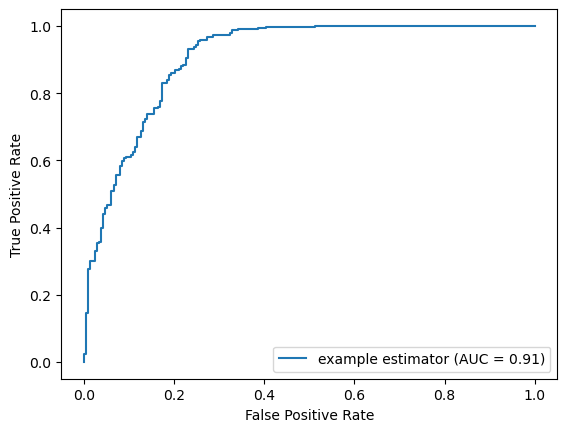

In [134]:
model = get_video_tran_model()

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=keras.losses.binary_crossentropy,
    metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer-kfold_05'
model.load_weights(checkpoint_filepath)
test_version(model, x_test, y_test, -0.15)

Sensitivity:75.12 
Specificity:93.59 
PPV:84.21 
NPV:89.21 
Accuracy:87.81 
Loss:0.3516
[[160  53]
 [ 30 438]]


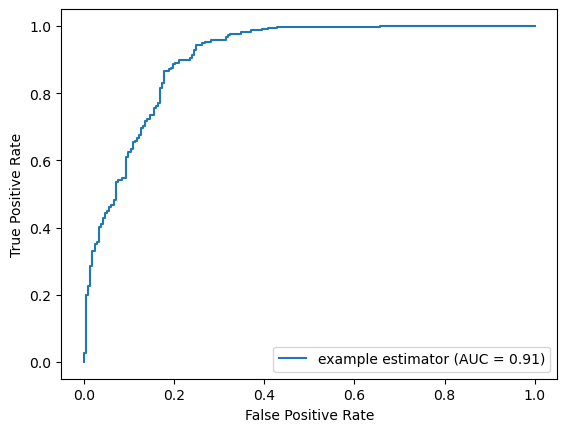

In [120]:
# keras.utils.set_random_seed(1)

# model = get_attn_lstm(200,64, 0.4,0.3)

# opt = keras.optimizers.Nadam(learning_rate=0.001)
# model.compile(
#     optimizer=opt,
#     loss=keras.losses.binary_crossentropy,
#     metrics=["accuracy"])
model.load_weights(filepath= '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-kfold_00')
test_version(model,x_test,y_test)


Sensitivity:76.53 
Specificity:91.45 
PPV:80.3 
NPV:89.54 
Accuracy:86.78 
Loss:0.3557
[[163  50]
 [ 40 428]]


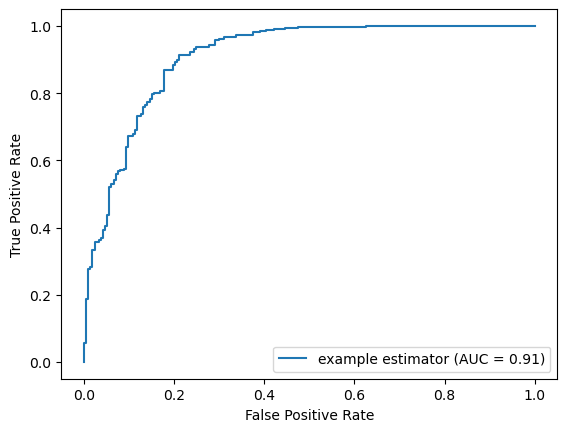

In [123]:
model = get_conv_model(200,64, 0.4,0.3)

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=keras.losses.binary_crossentropy,
    metrics=["accuracy"])

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/conv1d-kfold_0'+str(fold)

model.load_weights(checkpoint_filepath)
test_version(model,x_test,y_test)


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

tf.config.experimental.enable_op_determinism()

def test_version(model, x_test, y_test, offset=0):

    y_pred = model(x_test, training=False)
        
    y_pred = y_pred.numpy() + offset
    cm = confusion_matrix(y_test, y_pred.round())
        
    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])
    loss = metrics.log_loss(y_test, y_pred)

    print('Sensitivity:{:.4}'.format(sensitivity*100),
          '\nSpecificity:{:.4}'.format(sepecifity*100),
          '\nPPV:{:.4}'.format(ppv*100),
          '\nNPV:{:.4}'.format(npv*100),
          '\nAccuracy:{:.4}'.format(accuracy*100),
          '\nLoss:{:.4}'.format(loss))
    print(cm)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    return display.plot(), [roc_auc, sensitivity, sepecifity, accuracy]
    
def test_turku(model, x_test, y_test, offset=0):

    _, y_pred = model(x_test, training=False)
        
    y_pred = y_pred.numpy() + offset
    cm = confusion_matrix(y_test, y_pred.round())
        
    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])
    loss = metrics.log_loss(y_test, y_pred)

    print('Sensitivity:{:.4}'.format(sensitivity*100),
          '\nSpecificity:{:.4}'.format(sepecifity*100),
          '\nPPV:{:.4}'.format(ppv*100),
          '\nNPV:{:.4}'.format(npv*100),
          '\nAccuracy:{:.4}'.format(accuracy*100),
          '\nLoss:{:.4}'.format(loss))
    print(cm)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')

    return display.plot(), [roc_auc, sensitivity, sepecifity, accuracy]

[2 4 8 6 7 9 1 3 5]
[0]
Sensitivity:70.42 
Specificity:89.74 
PPV:75.76 
NPV:86.96 
Accuracy:83.7 
Loss:0.4559
[[150  63]
 [ 48 420]]


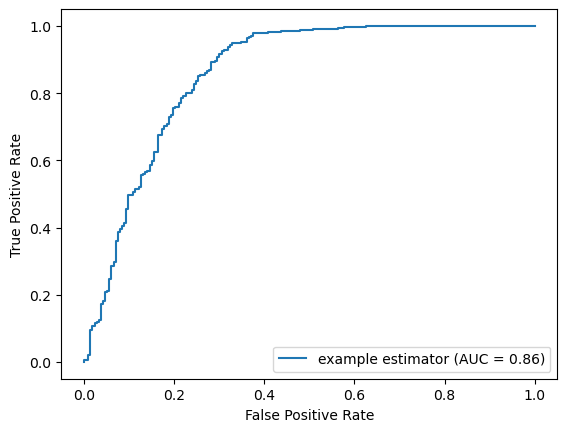

[0 2 4 8 6 7 9 3 5]
[1]
Sensitivity:67.09 
Specificity:91.72 
PPV:80.93 
NPV:84.19 
Accuracy:83.26 
Loss:0.4665
[[157  77]
 [ 37 410]]


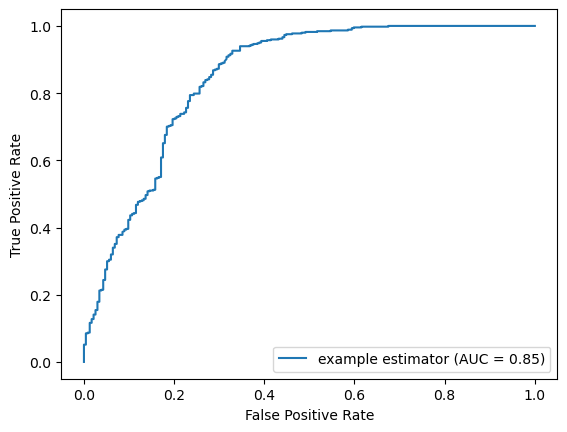

[0 4 8 6 7 9 1 3 5]
[2]
Sensitivity:61.6 
Specificity:91.67 
PPV:79.78 
NPV:81.73 
Accuracy:81.2 
Loss:0.4892
[[146  91]
 [ 37 407]]


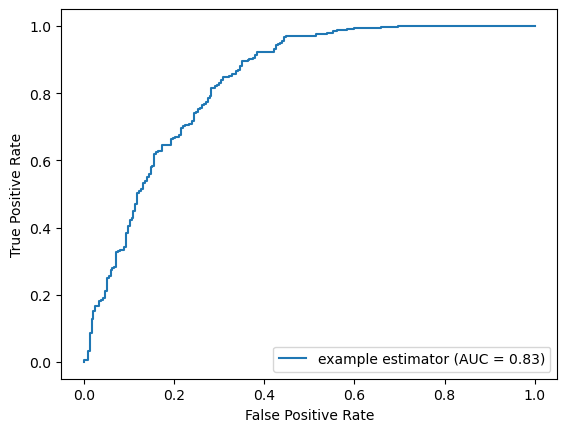

[0 2 4 8 6 7 9 1 5]
[3]
Sensitivity:67.83 
Specificity:90.24 
PPV:78.0 
NPV:84.62 
Accuracy:82.67 
Loss:0.5289
[[156  74]
 [ 44 407]]


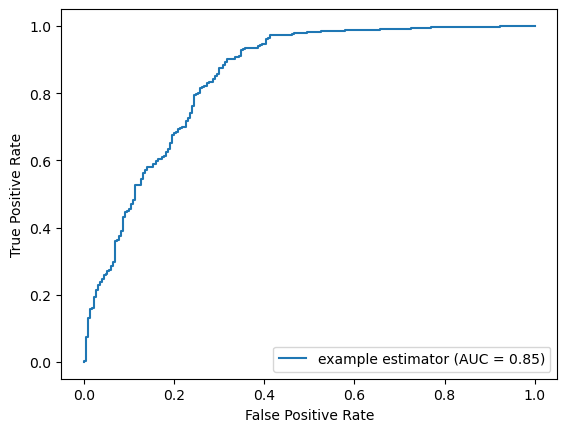

[0 2 8 6 7 9 1 3 5]
[4]
Sensitivity:66.36 
Specificity:87.93 
PPV:72.0 
NPV:84.82 
Accuracy:81.06 
Loss:0.4751
[[144  73]
 [ 56 408]]


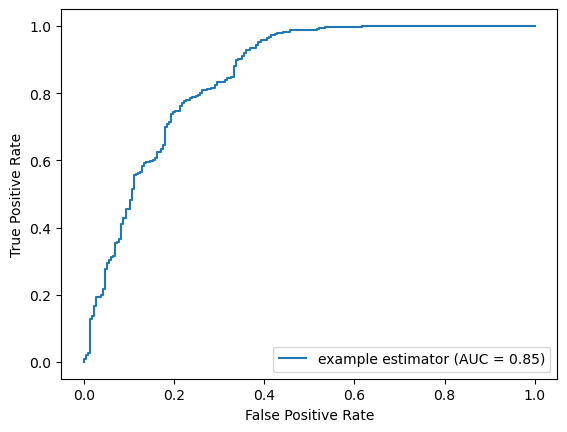

[0 2 4 8 6 7 9 1 3]
[5]
Sensitivity:71.49 
Specificity:92.48 
PPV:82.74 
NPV:86.54 
Accuracy:85.44 
Loss:0.44
[[163  65]
 [ 34 418]]


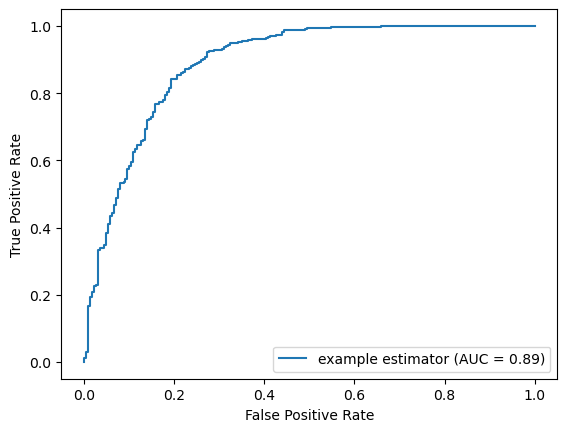

[0 2 4 8 7 9 1 3 5]
[6]
Sensitivity:64.13 
Specificity:87.96 
PPV:72.22 
NPV:83.4 
Accuracy:80.15 
Loss:0.5034
[[143  80]
 [ 55 402]]


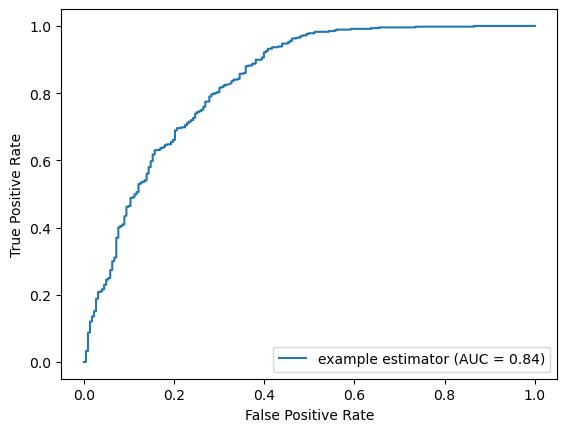

[0 2 4 8 6 9 1 3 5]
[7]
Sensitivity:70.61 
Specificity:91.39 
PPV:83.71 
NPV:83.22 
Accuracy:83.38 
Loss:0.4474
[[185  77]
 [ 36 382]]


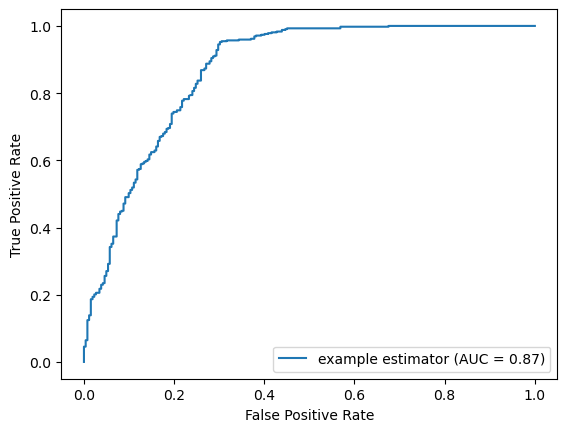

In [44]:
model = get_model()

dt = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy'])
for fold in range(0,8):
    _,_, test_generator = get_turku_generators(files,fold,1)
    t_len = test_generator.__len__()
    x_test = np.zeros([t_len,96,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i],y= test_generator.__getitem__(i)
        y_test[i] = y[1]

    model_dir = '/home/shared/model_checkpoint_paige/scan/turku_fold_0'+str(fold)
    model.load_weights(model_dir)
    opt = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    plot, data = test_turku(model, x_test, y_test)
    plt.show(plot)
    dt = dt.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3]}, ignore_index=True)

[2 4 8 6 7 9 1 3 5]
[0]
Sensitivity:74.18 
Specificity:91.24 
PPV:79.4 
NPV:88.59 
Accuracy:85.9 
Loss:0.3675
[[158  55]
 [ 41 427]]


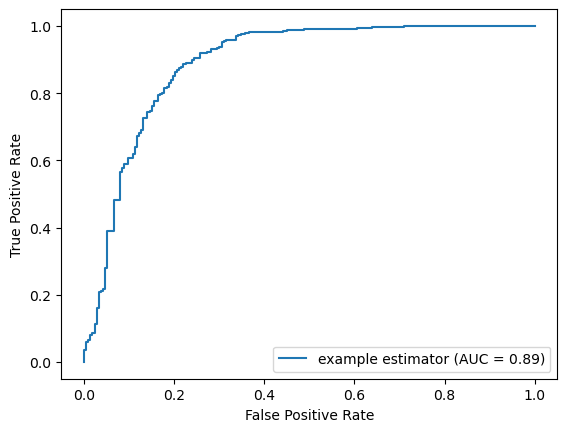

[0 2 4 8 6 7 9 3 5]
[1]
Sensitivity:70.94 
Specificity:91.95 
PPV:82.18 
NPV:85.8 
Accuracy:84.73 
Loss:0.3803
[[166  68]
 [ 36 411]]


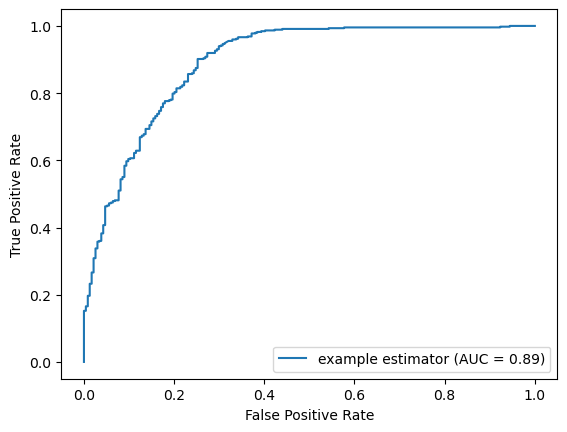

[0 4 8 6 7 9 1 3 5]
[2]
Sensitivity:81.01 
Specificity:83.56 
PPV:72.45 
NPV:89.18 
Accuracy:82.67 
Loss:0.3865
[[192  45]
 [ 73 371]]


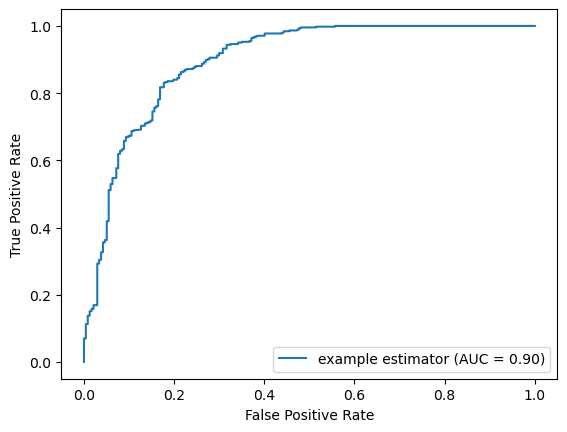

[0 2 4 8 6 7 9 1 5]
[3]
Sensitivity:73.91 
Specificity:89.36 
PPV:77.98 
NPV:87.04 
Accuracy:84.14 
Loss:0.4177
[[170  60]
 [ 48 403]]


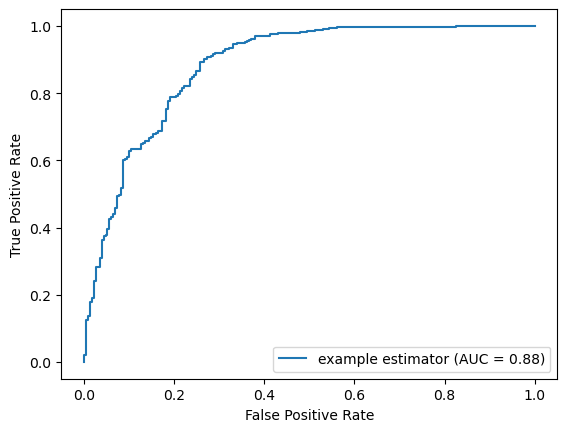

[0 2 8 6 7 9 1 3 5]
[4]
Sensitivity:76.5 
Specificity:86.21 
PPV:72.17 
NPV:88.69 
Accuracy:83.11 
Loss:0.4265
[[166  51]
 [ 64 400]]


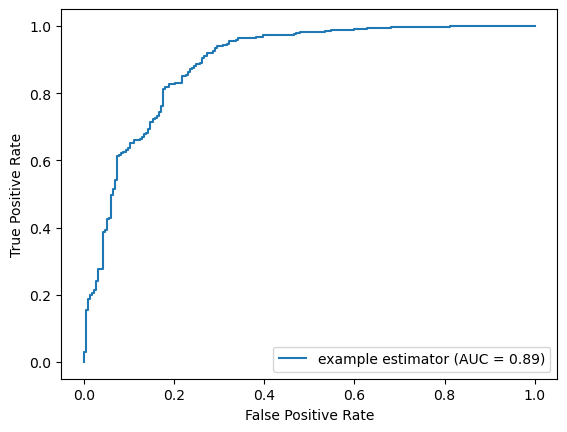

[0 2 4 8 6 7 9 1 3]
[5]
Sensitivity:82.02 
Specificity:90.27 
PPV:80.95 
NPV:90.87 
Accuracy:87.5 
Loss:0.3281
[[187  41]
 [ 44 408]]


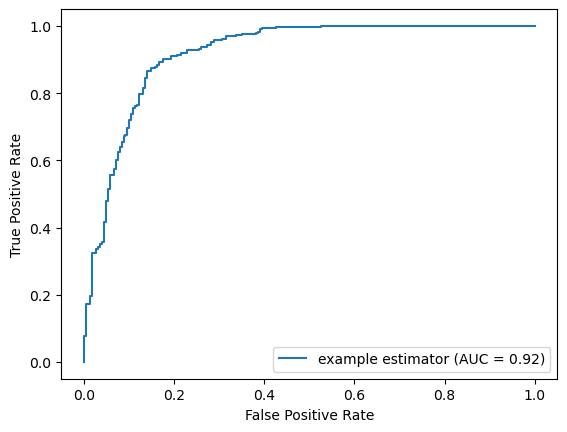

[0 2 4 8 7 9 1 3 5]
[6]
Sensitivity:73.09 
Specificity:91.9 
PPV:81.5 
NPV:87.5 
Accuracy:85.74 
Loss:0.3747
[[163  60]
 [ 37 420]]


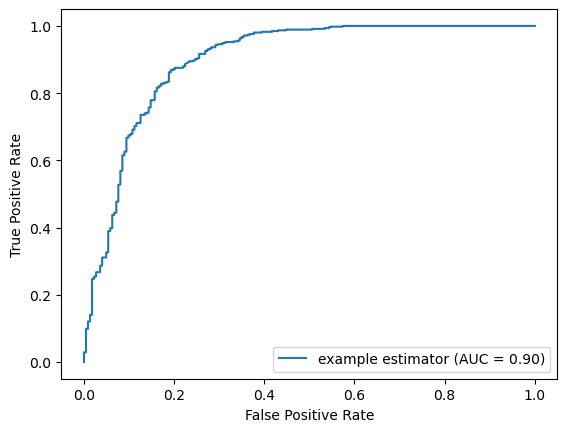

[0 2 4 8 6 9 1 3 5]
[7]
Sensitivity:77.48 
Specificity:90.43 
PPV:83.54 
NPV:86.5 
Accuracy:85.44 
Loss:0.3632
[[203  59]
 [ 40 378]]


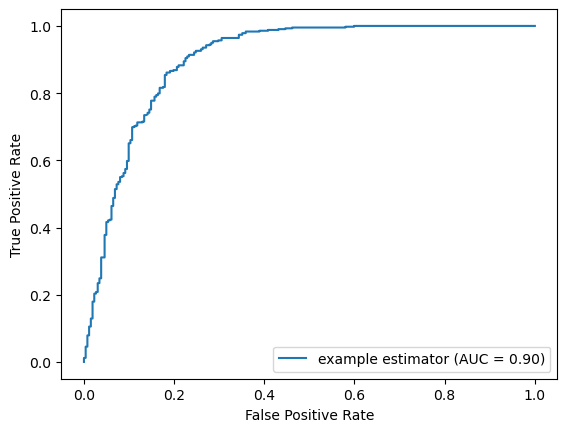

[0 2 4 6 7 9 1 3 5]
[8]
Sensitivity:77.78 
Specificity:91.3 
PPV:83.26 
NPV:88.08 
Accuracy:86.47 
Loss:0.3531
[[189  54]
 [ 38 399]]


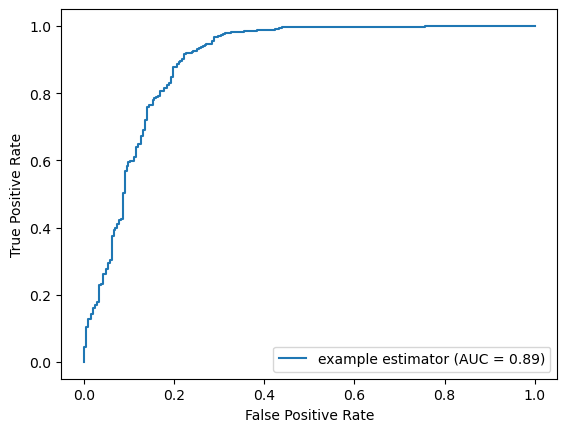

[0 2 4 8 6 7 1 3 5]
[9]
Sensitivity:69.07 
Specificity:93.02 
PPV:84.02 
NPV:84.98 
Accuracy:84.71 
Loss:0.4076
[[163  73]
 [ 31 413]]


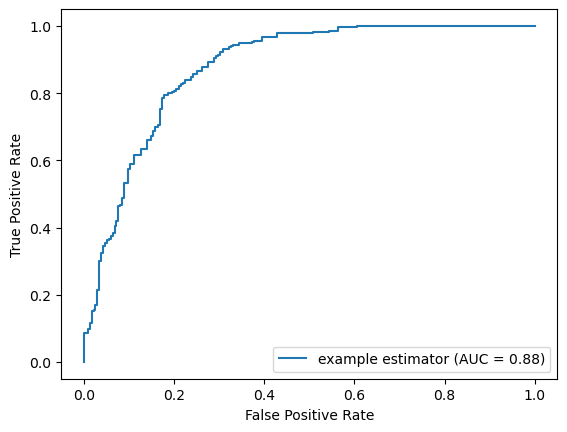

In [46]:
seq_len = 208

do = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy'])

for fold in range(0,10):

    model = get_attn_lstm(seq_len)

    if fold == 3 or fold == 0:
        np_dir = '/home/shared/nps/coat_diff_0'
    else:
        np_dir = '/home/shared/nps/coat_np_0'

    batch_size = 1
    _,_, test_gen = get_generators(files, fold, 
                                                            batch_size, 
                                                            'tot', 
                                                            'feats', 
                                                            True, 
                                                            seq_len=seq_len, 
                                                            np_dir=np_dir, 
                                                            crop=False,
                                                            osa=False
                                                           )
    
    t_len = test_gen.__len__()
    x_test = np.zeros([t_len,208,num_features])
    y_test = np.zeros([t_len,1])
    for i in range(0,t_len):
        x_test[i],y= test_gen.__getitem__(i)
        y_test[i] = y

    lr = 0.001
    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(
            optimizer=opt,
            loss=keras.losses.binary_crossentropy,
            metrics=["accuracy",]
        )

    checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-kfold_0'+str(fold)
    model.load_weights(checkpoint_filepath)
             
    plot, data = test_version(model, x_test,y_test)
    plt.show(plot)
    do = do.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3]}, ignore_index=True)

In [47]:
dt

,fold,auc,sensitivity,specificity,accuracy
0,0.0,0.859295,0.704225,0.897436,0.837004
1,1.0,0.848276,0.67094,0.917226,0.832599
2,2.0,0.833904,0.616034,0.916667,0.812041
3,3.0,0.84666,0.678261,0.902439,0.826725
4,4.0,0.852713,0.663594,0.87931,0.810573
5,5.0,0.889351,0.714912,0.924779,0.854412
6,6.0,0.835616,0.641256,0.87965,0.801471
7,7.0,0.868343,0.706107,0.913876,0.833824


In [59]:
do[:8]

,fold,auc,sensitivity,specificity,accuracy
0,0.0,0.889842,0.741784,0.912393,0.859031
1,1.0,0.891833,0.709402,0.919463,0.847283
2,2.0,0.896073,0.810127,0.835586,0.826725
3,3.0,0.882127,0.73913,0.89357,0.84141
4,4.0,0.89094,0.764977,0.862069,0.831131
5,5.0,0.91918,0.820175,0.902655,0.875
6,6.0,0.898578,0.730942,0.919037,0.857353
7,7.0,0.900047,0.774809,0.904306,0.854412


In [63]:
scipy.stats.ttest_rel(dt.accuracy, do[:8].accuracy)

Ttest_relResult(statistic=-4.7525549438186205, pvalue=0.002077339114137002)

In [41]:
test_explote= test_explote.drop_duplicates(subset='StudyInstanceUID', keep='first')

In [42]:
true_pos = test_explote[(test_explote.negative_exam_for_pe == False) & (test_explote.pred_results ==False)]
false_pos = test_explote[(test_explote.negative_exam_for_pe == True) & (test_explote.pred_results ==False)]

true_neg = test_explote[(test_explote.negative_exam_for_pe == True) & (test_explote.pred_results ==True)]
false_neg = test_explote[(test_explote.negative_exam_for_pe == False) & (test_explote.pred_results ==True)]

In [43]:
true_pos.mean()

negative_exam_for_pe          0.000000
pred_results                  0.000000
pe_present_on_image           0.014815
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.007407
rv_lv_ratio_gte_1             0.451852
rv_lv_ratio_lt_1              0.548148
leftsided_pe                  0.814815
chronic_pe                    0.059259
true_filling_defect_not_pe    0.000000
rightsided_pe                 0.888889
acute_and_chronic_pe          0.066667
central_pe                    0.288889
indeterminate                 0.000000
contains_lung                 0.088889
dtype: float64

In [44]:
false_neg.mean()

negative_exam_for_pe          0.000000
pred_results                  1.000000
pe_present_on_image           0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.073171
rv_lv_ratio_gte_1             0.182927
rv_lv_ratio_lt_1              0.817073
leftsided_pe                  0.548780
chronic_pe                    0.243902
true_filling_defect_not_pe    0.000000
rightsided_pe                 0.682927
acute_and_chronic_pe          0.097561
central_pe                    0.024390
indeterminate                 0.000000
contains_lung                 0.097561
dtype: float64

In [ ]:
test_explote[(test_explote.negative_exam_for_pe ==True) &
             (test_explote.true_filling_defect_not_pe == True)].pred_results.mean()

In [ ]:
test_explote[(test_explote.negative_exam_for_pe ==True) &
             (test_explote.true_filling_defect_not_pe == False)].pred_results.mean()

In [ ]:
false_pos.mean()

In [ ]:
true_neg.mean()

 0.6221198156682027 
 0.8839285714285714 
 0.7219251336898396 
 0.8284518828451883 
 0.7984962406015037
[[135  82]
 [ 52 396]]


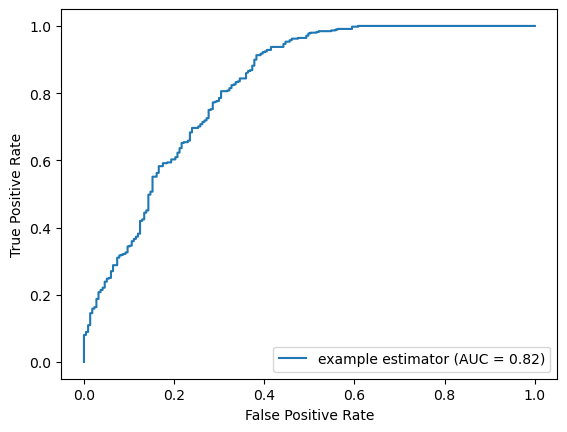

In [46]:
test_version(model, )

In [ ]:
y_test_seq = np.asarray(y_seq_test).flatten()
y_pred_seq = np.asarray(y_pred_seq).flatten()
cm = confusion_matrix(y_test_seq, y_pred_seq.round())

sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

ppv = cm[0][0]/(cm[0][0]+cm[1][0])
npv = cm[1][1]/(cm[1][1]+cm[0][1])

print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
print(cm)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
pred = model.predict(x)

In [ ]:
(131+153)/(131+71+50+153)

In [ ]:
from sklearn.metrics import confusion_matrix

# pred = pred - 0.03
cm = confusion_matrix(y, pred.round())
cm

In [ ]:
153/203

In [ ]:
cm[1,1]/(cm[1,0]+cm[1,1])

In [ ]:
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity, sensitivity

In [ ]:
y.sum()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()